In [191]:
import pandas as pd
from prophet import Prophet
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams 
from   datetime                           import  datetime, timedelta
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.graphics.gofplots        import  qqplot
from statsmodels.tsa.seasonal             import  seasonal_decompose
from statsmodels.tsa.arima_model          import  ARIMA,ARMA
from statsmodels.tsa.statespace.sarimax   import  SARIMAX
import warnings
#import seaborn as sns
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error

In [192]:
import uvicorn
from fastapi import FastAPI
import joblib

In [193]:
veg = str(input("Enter the commodity = "))

In [194]:
market = str(input("Enter the market = "))

In [195]:
print(veg)

Tomato


In [196]:
print(market)

Bowenpally


In [197]:
dt = pd.date_range(start ='08-01-2023', end ='31-07-2024', freq ='D' )
dt

DatetimeIndex(['2023-08-01', '2023-08-02', '2023-08-03', '2023-08-04',
               '2023-08-05', '2023-08-06', '2023-08-07', '2023-08-08',
               '2023-08-09', '2023-08-10',
               ...
               '2024-07-22', '2024-07-23', '2024-07-24', '2024-07-25',
               '2024-07-26', '2024-07-27', '2024-07-28', '2024-07-29',
               '2024-07-30', '2024-07-31'],
              dtype='datetime64[ns]', length=366, freq='D')

In [198]:
df = pd.read_excel('Book.xlsx',parse_dates=['Reported Date'],sheet_name = veg, index_col = 'Reported Date')

In [199]:
df1_price_new = pd.DataFrame(columns=['Market Name','Min Price (Rs./Quintal)'],data=df,index=dt)

In [200]:
df1_price_new.head()

,Market Name,Min Price (Rs./Quintal)
2023-08-01,NaN,NaN
2023-08-02,NaN,NaN
2023-08-03,NaN,NaN
2023-08-04,NaN,NaN
2023-08-05,NaN,NaN


In [201]:
df1_price_new['Market Name'].fillna(market,inplace=True)

In [202]:
df1_price_new['Min Price (Rs./Quintal)'].fillna(method='bfill',inplace=True)
df1_price_new['Min Price (Rs./Quintal)'].fillna(method='ffill',inplace=True)

In [203]:
df1_price_new.isnull().sum()

Market Name                0
Min Price (Rs./Quintal)    0
dtype: int64

In [204]:
df1_price = pd.DataFrame(columns=['Market Name','Min Price (Rs./Quintal)'],data=df1_price_new)

In [205]:
df1_price = df1_price.reset_index()

In [206]:
target = pd.DataFrame()

In [207]:
df1_price.rename({'Market Name':'Market'},axis=1,inplace=True)

In [208]:
df1_price = df1_price.rename({'Min Price (Rs./Quintal)':'y','index':'ds'},axis=1)
df1_price.head()

,ds,Market,y
0,2023-08-01,Bowenpally,2400.0
1,2023-08-02,Bowenpally,2400.0
2,2023-08-03,Bowenpally,2400.0
3,2023-08-04,Bowenpally,2400.0
4,2023-08-05,Bowenpally,2400.0


In [209]:
Markets = df1_price.groupby('Market')

In [210]:
df1_price['cap'] = min(df1_price['y']) + max(df1_price['y'])

In [211]:
df1_price['floor'] = min(df1_price['y']) / 2

17:04:35 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] done processing


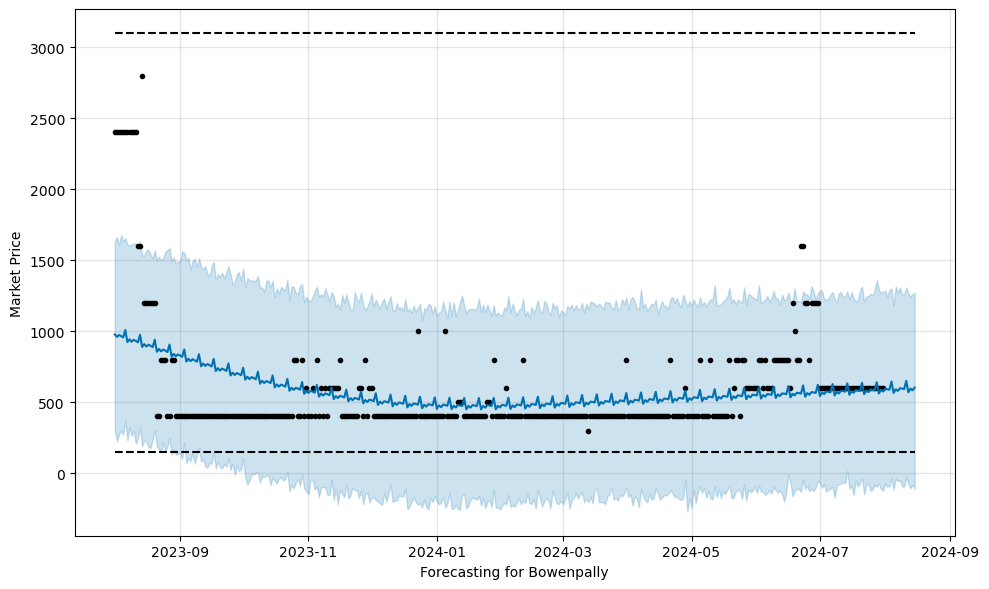

In [212]:
for Market in Markets.groups:
    group = Markets.get_group(Market)
    m = Prophet(growth='logistic',interval_width=0.95, weekly_seasonality=True,daily_seasonality=True,seasonality_mode='additive')
    #m = Prophet(growth='logistic',interval_width=0.95,daily_seasonality=True,weekly_seasonality=True,seasonality_mode='additive')    
    m.fit(group)
    future = m.make_future_dataframe(periods=15)
    future['cap'] = min(df1_price['y']) + max(df1_price['y'])
    future['floor'] = min(df1_price['y']) / 2
    #print(future)
    forecast = m.predict(future)   
    m.plot(forecast,xlabel='Forecasting for '+ Market,ylabel='Market Price')
    forecast = forecast.rename(columns=({'yhat':'yhat_'+ 'Market_Price'}))
    target = pd.merge(target,forecast.set_index('ds'),how='outer',left_index=True,right_index=True)

In [213]:
target

,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat_Market_Price
ds,,,,,,,,,,,,,,,,,,,,
2023-08-01,1846.165819,3100.0,150.0,305.815246,1627.862268,1846.165819,1846.165819,-869.104239,-869.104239,-869.104239,-865.40838,-865.40838,-865.40838,-3.695859,-3.695859,-3.695859,0.0,0.0,0.0,977.061579
2023-08-02,1841.342110,3100.0,150.0,223.776559,1660.908050,1841.342110,1841.342110,-881.316467,-881.316467,-881.316467,-865.40838,-865.40838,-865.40838,-15.908087,-15.908087,-15.908087,0.0,0.0,0.0,960.025644
2023-08-03,1836.513668,3100.0,150.0,272.809738,1609.421430,1836.513668,1836.513668,-863.348930,-863.348930,-863.348930,-865.40838,-865.40838,-865.40838,2.059450,2.059450,2.059450,0.0,0.0,0.0,973.164738
2023-08-04,1831.680593,3100.0,150.0,299.882554,1674.795317,1831.680593,1831.680593,-866.102101,-866.102101,-866.102101,-865.40838,-865.40838,-865.40838,-0.693721,-0.693721,-0.693721,0.0,0.0,0.0,965.578492
2023-08-05,1826.842987,3100.0,150.0,271.977958,1636.552180,1826.842987,1826.842987,-870.799283,-870.799283,-870.799283,-865.40838,-865.40838,-865.40838,-5.390903,-5.390903,-5.390903,0.0,0.0,0.0,956.043703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-11,1463.560448,3100.0,150.0,-29.493521,1307.391751,1460.792471,1466.379859,-813.322215,-813.322215,-813.322215,-865.40838,-865.40838,-865.40838,52.086165,52.086165,52.086165,0.0,0.0,0.0,650.238233
2024-08-12,1464.208467,3100.0,150.0,-73.706144,1266.999587,1461.149058,1467.534029,-893.865424,-893.865424,-893.865424,-865.40838,-865.40838,-865.40838,-28.457044,-28.457044,-28.457044,0.0,0.0,0.0,570.343043
2024-08-13,1464.856549,3100.0,150.0,-105.615967,1244.506928,1461.413906,1468.695639,-869.104239,-869.104239,-869.104239,-865.40838,-865.40838,-865.40838,-3.695859,-3.695859,-3.695859,0.0,0.0,0.0,595.752310


In [214]:
target['yhat_Market_Price']

ds
2023-08-01    977.061579
2023-08-02    960.025644
2023-08-03    973.164738
2023-08-04    965.578492
2023-08-05    956.043703
                 ...    
2024-08-11    650.238233
2024-08-12    570.343043
2024-08-13    595.752310
2024-08-14    584.188227
2024-08-15    602.803971
Name: yhat_Market_Price, Length: 381, dtype: float64

In [215]:
Price = pd.DataFrame(data=target['yhat_Market_Price'])

In [216]:
Price.tail(15)

,yhat_Market_Price
ds,
2024-08-01,593.734834
2024-08-02,591.629040
2024-08-03,587.579301
2024-08-04,645.703877
2024-08-05,565.808241
2024-08-06,591.217063
2024-08-07,579.652537
2024-08-08,598.267839
2024-08-09,596.162497


In [217]:
def mape(actual,pred):
    actual, pred = np.array(actual),np.array(pred)
    return np.mean(np.abs((actual-pred)/actual))*100

In [218]:
mape_min_price = mape(df1_price_new['Min Price (Rs./Quintal)'],Price['yhat_Market_Price'][:df1_price_new.shape[0]])

In [219]:
mape_min_price

34.0689550148656

In [220]:
dump_model = 'min_price15days'+'_'+veg


In [221]:
print(dump_model)

min_price15days_Tomato


In [222]:
joblib.dump(m,'min_price15days.joblib')

['min_price15days.joblib']